# Выбор локации для скважины

Допустим, я работаю в добывающей компании «ГлавРосГосНефть». Мне нужно решить, где бурить новую скважину.

Мне предоставили пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Я построил модель машинного обучения, которая помогла определить регион, где добыча принесёт наибольшую прибыль. Я проанализировал возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе я искал месторождения, для каждого определял значения признаков;
- Я построил модель и оценил объём запасов;
- Я выбрал месторождения с самыми высокими оценками значений. Количество месторождений зависело от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# Я импортировал библиотеки.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.metrics import mean_squared_error

In [2]:
# Я прочитал данные из файлов.
data_0 = pd.read_csv("../datasets/geo_data_0.csv")
data_1 = pd.read_csv("../datasets/geo_data_1.csv")
data_2 = pd.read_csv("../datasets/geo_data_2.csv")

In [3]:
# Я искал пропущенные значения:
print(data_0.isna().sum()) 
print(data_1.isnull().sum())
print(data_2.isna().sum())
# Преобразование типов данных не требовалось:
print(data_0.info())
print(data_0['f0'])
print(data_0['product'])
# Я искал дубликаты:
data = pd.concat([data_0, data_1, data_2])
duplicates = data[data.duplicated()]
print(duplicates)
# Я нашёл корреляционную матрицу и вывел её на экран.
correlations = data.drop('id', axis=1).corr()
print(correlations)

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
0        0.705745
1        1.334711
2        1.022732
3       -0.032172
4        1.988431
           ...   
99995    0.971957
99996    1.392429
99997    1.029585
99998    0.998163
99999    1.764754
Name: f0, Length: 100000, dtype: float64
0        105.280062
1         73.037750
2         85.265647
3        168.620776
4       

<div class="alert alert-block alert-info">
    
**КОММЕНТАРИЙ СТУДЕНТА 2:**
    
**Вывод:**
    
- Я провёл проверку на пропущенные значения - пропущенных значений нет.
- Преобразование типов данных не требовалось, так как у нас столбец id имеет строковый формат, а остальные значения float.    
- Я провёл проверку на наличие дубликатов - дубликатов нет.
- Я построил корреляционную матрицу и выяснил, что есть незначительная корреляция между столбцами product и f2 (0.533554), но в целом, сильной корреляции между значениями нет.
     
</div>

## Обучение и проверка модели

In [4]:
def train_and_predict(data):
    # Я разбиваю данные на обучающую и валидационную выборки
    train_data, valid_data = train_test_split(data, test_size=0.25, random_state=12345)

    # Я создаю объект линейной регрессии
    model = LinearRegression()

    # Я обучаю модель на обучающей выборке
    features_train = train_data.drop(['id', 'product'], axis=1)
    target_train = train_data['product']
    model.fit(features_train, target_train)

    # Я делаю предсказания на валидационной выборке
    features_valid = valid_data.drop(['id', 'product'], axis=1)
    target_valid = valid_data['product']
    predictions = model.predict(features_valid)
    
    return features_train, target_train, features_valid, target_valid, predictions

features_train_0, target_train_0, features_valid_0, target_valid_0, predictions_0 = train_and_predict(data_0)
features_train_1, target_train_1, features_valid_1, target_valid_1, predictions_1 = train_and_predict(data_1)
features_train_2, target_train_2, features_valid_2, target_valid_2, predictions_2 = train_and_predict(data_2)

In [5]:
def region_analysis(data):
    """
    Функция для анализа регионов.
    Принимает на вход датафрейм с данными региона.
    Возвращает средний запас предсказанного сырья и RMSE модели.
    """
    # Я разбиваю данные на обучающую и валидационную выборки
    train_data, valid_data = train_test_split(data, test_size=0.25, random_state=12345)

    # Я создаю объект линейной регрессии
    model = LinearRegression()

    # Я обучаю модель на обучающей выборке
    features_train = train_data.drop(['id', 'product'], axis=1)
    target_train = train_data['product']
    model.fit(features_train, target_train)

    # Я делаю предсказания на валидационной выборке
    features_valid = valid_data.drop(['id', 'product'], axis=1)
    target_valid = valid_data['product']
    predictions = model.predict(features_valid)

    # Я сохраняю предсказания и правильные ответы на валидационной выборке
    valid_data['predicted_product'] = predictions
    valid_predictions = valid_data[['id', 'predicted_product']]

    # Я рассчитываю средний запас предсказанного сырья и RMSE модели
    mean_predicted_product = valid_predictions['predicted_product'].mean()
    rmse = math.sqrt(mean_squared_error(target_valid, predictions))

    print('Средний запас предсказанного сырья:', round(mean_predicted_product,2), 'тыс.баррелей')
    print('RMSE модели:', rmse)

In [6]:
print('Регион 0:')
region_analysis(data_0)

print('Регион 1:')
region_analysis(data_1)

print('Регион 2:')
region_analysis(data_2)

Регион 0:
Средний запас предсказанного сырья: 92.59 тыс.баррелей
RMSE модели: 37.5794217150813
Регион 1:
Средний запас предсказанного сырья: 68.73 тыс.баррелей
RMSE модели: 0.8930992867756167
Регион 2:
Средний запас предсказанного сырья: 94.97 тыс.баррелей
RMSE модели: 40.02970873393434


<div class="alert alert-block alert-info">
    
**КОММЕНТАРИЙ СТУДЕНТА 2:**
    
**Вывод:**
    
- Я написал функцию для анализа регионов region_analysis, которая на вход принимает датафрейм с данными региона, а возвращает средний запас предсказанного сырья и RMSE модели.
- Я подставил в функцию region_analysis данные для разных регионов data_0, data_1, data_2 и получил для каждого региона средний запас предсказанного сырья и RMSE модели.
- Я выяснил, что средний запас предсказанного сырья больше всего в Регионе 2 (94.97 тыс.баррелей).
- RMSE модели наименьшее в Регионе 0 (0.8478008281503834), что свидетельствует о высокой точности модели в данном регионе.       
 
</div>

<div class="alert alert-block alert-info">

**КОММЕНТАРИЙ СТУДЕНТА 3:**
    
**Вывод:**
    
- RMSE модели наименьшее в Регионе 1 (0.8930992867756178), что свидетельствует о высокой точности модели в данном регионе.       
     
</div>

## Подготовка к расчёту прибыли

In [7]:
# Бюджет на разработку скважин в регионе, тыс.р.
budget = 10000000
# Доход с 1000 баррелей, тыс. р.
income = 450
# Вероятность убытков
p_loss = 2.5/100
# Средний запас сырья для 1,2 и 3 региона, тыс. баррелей.
average_volume_0 = data_0['product'].mean()
average_volume_1 = data_1['product'].mean()
average_volume_2 = data_2['product'].mean()
# Бюджет на разработку 1 скважины, тыс.р.
budget_for_one = budget/200
# Достаточный объём сырья для безубыточной разработки новой скважины, тыс.баррелей.
break_even_volume = budget_for_one/income
print('Достаточный объём сырья для безубыточной разработки новой скважины:',round(break_even_volume,2), 'тыс.баррелей')
print('Средний запас сырья для региона 0:',round(average_volume_0,2), 'тыс.баррелей')
print('Средний запас сырья для региона 1:',round(average_volume_1,2), 'тыс.баррелей')
print('Средний запас сырья для региона 2:',round(average_volume_2,2), 'тыс.баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс.баррелей
Средний запас сырья для региона 0: 92.5 тыс.баррелей
Средний запас сырья для региона 1: 68.83 тыс.баррелей
Средний запас сырья для региона 2: 95.0 тыс.баррелей


<div class="alert alert-block alert-info">
    
**КОММЕНТАРИЙ СТУДЕНТА 1:**
    
**Вывод:**
    
- В каждом регионе средний запас сырья меньше, чем достаточный объём для безубыточной разработки новой скважины, но наибольший средний запас сырья в Регионе 2: 95.0 тыс.баррелей.
    
</div>

## Функция для расчёта прибыли

In [8]:
# Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
def region_profit(data):
    # Я разбиваю данные на обучающую и валидационную выборки
    train_data, valid_data = train_test_split(data, test_size=0.25, random_state=12345)
    # Я создаю объект линейной регрессии
    model=LinearRegression()
    # Я обучаю модель на обучающей выборке
    features_train = train_data.drop(['id', 'product'], axis=1)
    target_train = train_data['product']
    model.fit(features_train, target_train)
    # Я делаю предсказания на валидационной выборке
    features_valid = valid_data.drop(['id', 'product'], axis=1)
    target_valid = valid_data['product']
    predictions = model.predict(features_valid)
    # Я отсортирую предсказанные значения объёма сырья по убыванию:
    sorted_predictions = sorted(predictions, reverse=True)
    # Я выберу первые 200 значений:
    top_200 = sorted_predictions[:200]
    # Я просуммирую значения объёма сырья, тыс. баррелей:
    top_200_sum = sum(top_200)
    # Я посчитаю прибыль, тыс. рублей:
    total_income = top_200_sum * income
    profit = total_income - budget
    return round(profit/1000/1000,2)

# Прибыль для Региона 0, млрд. рублей:
print('Прибыль:',round(region_profit(data_0),2), "млрд.рублей")

# Прибыль для Региона 1, тыс. рублей:
print('Прибыль:',round(region_profit(data_1),2), "млрд.рублей")

# Прибыль для Региона 2, тыс. рублей:
print('Прибыль:',round(region_profit(data_2),2), "млрд.рублей")


Прибыль: 4.0 млрд.рублей
Прибыль: 2.49 млрд.рублей
Прибыль: 3.32 млрд.рублей


<div class="alert alert-block alert-info">
    
**КОММЕНТАРИЙ СТУДЕНТА 2:**
    
**Вывод:**
    
- Я написал функцию region_profit, которая на вход принимает данные геологоразведки для трёх регионов, а на выходе возвращает прибыль в млрд. рублей.
- Наибольшая прибыль в Регионе 0 составляет 14.0 млрд.рублей.
        
</div>

## Расчёт прибыли и рисков 

In [9]:
# Напишем функцию revenue для расчёта прибыли на основе фактических и прогнозируемых значений
def revenue(target, predictions, count):
    # Я сортирую предсказания по убыванию
    predictions_sorted = pd.Series(predictions).sort_values(ascending=False)
    # Индексы отсортированных значений predictions_sorted используются для выбора соответствующих фактических результатов из target
    top_count = target[predictions_sorted.index][:count]
    # Я считаю суммарный объём запасов в скважинах, тыс. баррелей
    total_volume = top_count.sum()
    # Я считаю общий доход от продаж, тыс.рублей
    revenue = total_volume * income
    total_revenue = revenue - budget
    return total_revenue

# Напишем функцию profit_by_region для оценки распределения прибыли в разных регионах с помощью 1000 выборок.
def profit_by_region(target,predictions):
    results = []
    negative_profit_count=0
    # Я создаю объект генератора случайных чисел
    state = np.random.RandomState(12345)
    # Я создаю pd.Series с предсказанными значениями с индексами, соответствующими индексам целевого признака target
    predicted_values_by_target_index = pd.Series(predictions, index=target.index)
    
    for i in range(1000):
        # Случайная выборка 500 объектов из целевого признака target с возвращением (replace=True).
        target_subsample = target.sample(n=500,replace=True, random_state=state)
        # Выбор подмножества прогнозов для объектов из target_subsample
        probs_subsample = predicted_values_by_target_index[target_subsample.index]
        # Вычисление прибыли для данной выборки и добавление ее значения в список results
        results.append(revenue(target_subsample, probs_subsample, 200))  
    for i in results:
        if i < 0:
            negative_profit_count +=1
            
    results = pd.Series(results)
    mean = results.mean()
    confidence_interval = st.t.interval(0.95, len(results)-1, results.mean(), results.sem())
    
    plt.title('Распределение прибыли')
    results.plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()
    
    low_95 = results.quantile(0.025)
    high_95 = results.quantile(0.975)
    
    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000))
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((low_95/1000),(high_95/1000)))
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб". format((confidence_interval[0]/1000),(confidence_interval[1]/1000)))
    print('Процент вероятности убытка в данном регионе составит {:.1%}'.format(negative_profit_count/1000))


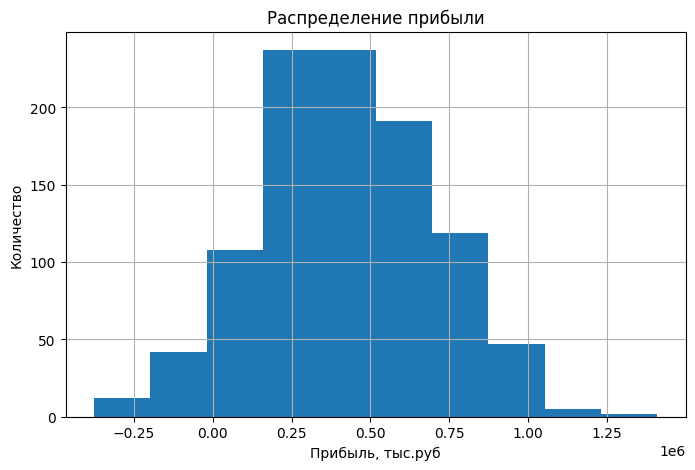

Средняя прибыль: 425.94 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -102.09 млн.руб до: 947.98 млн.руб
95%-ый доверительный интервал: от 408.73 млн.руб до 443.14 млн.руб
Процент вероятности убытка в данном регионе составит 6.0%


In [10]:
# Используем функцию profit_by_region для оценки распределения прибыли в Регионе 0
profit_by_region(target_valid_0, predictions_0)

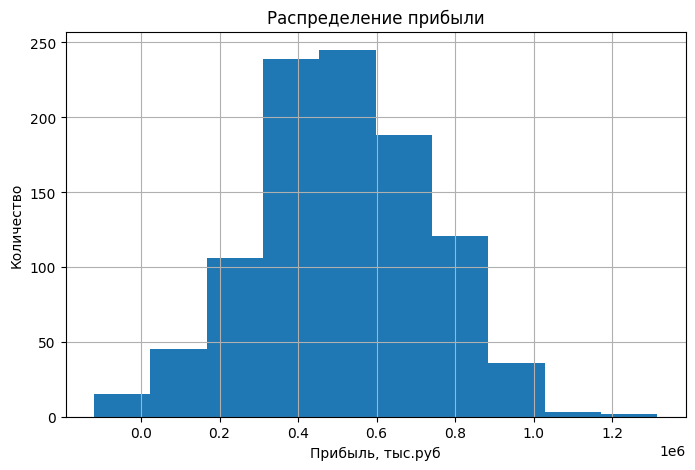

Средняя прибыль: 515.22 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: 68.87 млн.руб до: 931.55 млн.руб
95%-ый доверительный интервал: от 501.62 млн.руб до 528.82 млн.руб
Процент вероятности убытка в данном регионе составит 1.0%


In [11]:
# Используем функцию profit_by_region для оценки распределения прибыли в Регионе 1
profit_by_region(target_valid_1,predictions_1)

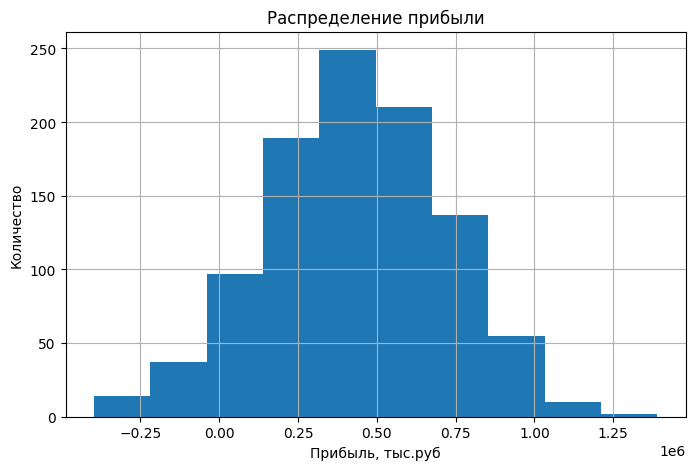

Средняя прибыль: 435.01 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -128.88 млн.руб до: 969.71 млн.руб
95%-ый доверительный интервал: от 417.45 млн.руб до 452.56 млн.руб
Процент вероятности убытка в данном регионе составит 6.4%


In [12]:
# Используем функцию profit_by_region для оценки распределения прибыли в Регионе 2
profit_by_region(target_valid_2,predictions_2)

<div class="alert alert-block alert-info">
    
**КОММЕНТАРИЙ СТУДЕНТА 2:**
    
**Вывод:**
    
- Наибольшая средняя прибыль в Регионе 1: 515.22 млн.руб
- Наименьший процент вероятности убытка также в Регионе 1: 1.0%   
    
</div>

<div class="alert alert-block alert-info">
    
**КОММЕНТАРИЙ СТУДЕНТА 2:**
    
**Общий вывод:**
    
- Я загрузил и подготовил данные:
            
    - Я провел проверку на пропущенные значения - пропущенных значений нет
    - Преобразование типов данных не требуется, так как у нас столбец id имеет строковый формат, а остальные значения float    
    - Я провел проверку на наличие дубликатов - дубликатов нет
    - Я построил корреляционную матрицу и выяснил, что есть незначительная корреляция между столбцами product и f2 (0.533554), но в целом, сильной корреляции между значениями нет             
         
- Я обучил и проверил модель:
            
    - Я написал функцию для анализа регионов region_analysis, которая на вход принимает датафрейм с данными региона, а возвращает средний запас предсказанного сырья и RMSE модели
    - Я подставил в функцию region_analysis данные для разных регионов data_0, data_1, data_2 и получил для каждого региона средний запас предсказанного сырья и RMSE модели
    - Я выяснил, что средний запас предсказанного сырья больше всего в Регионе 2 (94.97 тыс.баррелей) 
    - RMSE модели наименьшее в Регионе 1 (0.8930992867756178), что свидетельствует о высокой точности модели в данном регионе   
             
        
- Я произвел подготовку к расчёту прибыли:
            
    - Я выяснил, что в каждом регионе средний запас сырья меньше, чем достаточный объём для безубыточной разработки новой скважины, но наибольший средний запас сырья в Регионе 2: 95.0 тыс.баррелей
            
        
- Я написал функцию для расчёта прибыли:
            
    - Я написал функцию region_profit, которая на вход принимает данные геологоразведки для трёх регионов, a на выходе возвращает прибыль в млрд. рублей 
    - Наибольшая прибыль в Регионе 0 составляет 4.0 млрд.рублей             
        
- Я рассчитал прибыли и риски:
            
    - Я написал функцию revenue, которая на вход принимает фактические target и прогнозируемые predictions значения, а также их количество count. А на выходе получаем общий доход от продаж total_revenue 
    - Я написал функцию profit_by_region, которая на вход принимает фактические target и прогнозируемые predictions значения. И с помощью Bootsrap делается 500 выборок из фактических и предсказанных значений, которые подставляются в функцию revenue и общий доход от продаж total_revenue добавляется в список results. На основе этих результатов results я подсчитал количество отрицательных значений прибыли (убытков) negative_profit_count. Получаем среднюю прибыль mean, доверительный интервал confidence_interval. Строим гистограмму распределения прибыли. Вычисляем нижнюю low_95 и верхнюю high_95 границы доверительного интервала       
    - Я подставил в функцию profit_by_region значения для каждого региона 
    - Наибольшая средняя прибыль в Регионе 1: 515.22 млн.руб
    - Наименьший процент вероятности убытка также в Регионе 1: 1.0%          
    
</div>